In [3]:
import numpy as np 
import pandas as pd

day0_csv = pd.read_csv("/Users/jonathanlim/Desktop/Code_2022/IMC_Trading/IMC-Trading-Competition-1/Round1/Data/trades_round_1_day_0_nn.csv",delimiter=';')

In [19]:
day0_csv

,timestamp,buyer,seller,symbol,currency,price,quantity
0,100,NaN,NaN,PEARLS,SEASHELLS,10002.0,1
1,300,NaN,NaN,PEARLS,SEASHELLS,9998.0,2
2,300,NaN,NaN,PEARLS,SEASHELLS,9998.0,1
3,400,NaN,NaN,BANANAS,SEASHELLS,4899.0,9
4,500,NaN,NaN,BANANAS,SEASHELLS,4899.0,1
...,...,...,...,...,...,...,...
5162,998800,NaN,NaN,PEARLS,SEASHELLS,10002.0,1
5163,998800,NaN,NaN,BANANAS,SEASHELLS,4870.0,1
5164,999300,NaN,NaN,BANANAS,SEASHELLS,4875.0,17
5165,999500,NaN,NaN,BANANAS,SEASHELLS,4869.0,2


TypeError: show() got an unexpected keyword argument 'figsize'

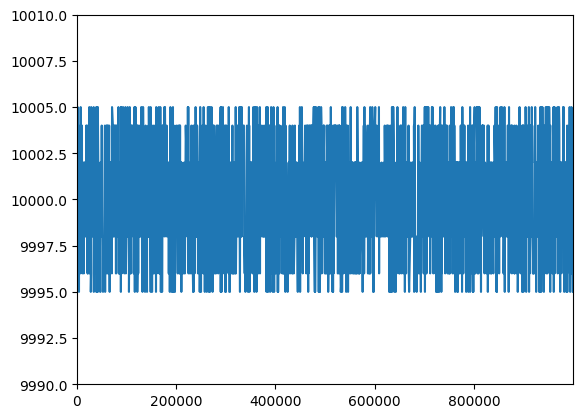

In [30]:
import matplotlib.pyplot as plt

pearls = day0_csv[day0_csv['symbol'] == 'PEARLS']
x = pearls['timestamp'].tolist()
y = pearls['price'].tolist()

plt.xlim([0, 999500])
plt.ylim([9990, 10010])

plt.plot(x,y)
plt.show(figsize=()) 

https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

In [15]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

# stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
stock_data = day0_csv[day0_csv['symbol']=='BANANAS']
stock_data.head()



,timestamp,buyer,seller,symbol,currency,price,quantity
3,400,NaN,NaN,BANANAS,SEASHELLS,4899.0,9
4,500,NaN,NaN,BANANAS,SEASHELLS,4899.0,1
7,1400,NaN,NaN,BANANAS,SEASHELLS,4891.0,1
8,1500,NaN,NaN,BANANAS,SEASHELLS,4896.0,1
11,2200,NaN,NaN,BANANAS,SEASHELLS,4896.0,16


Text(0, 0.5, 'Prices ($)')

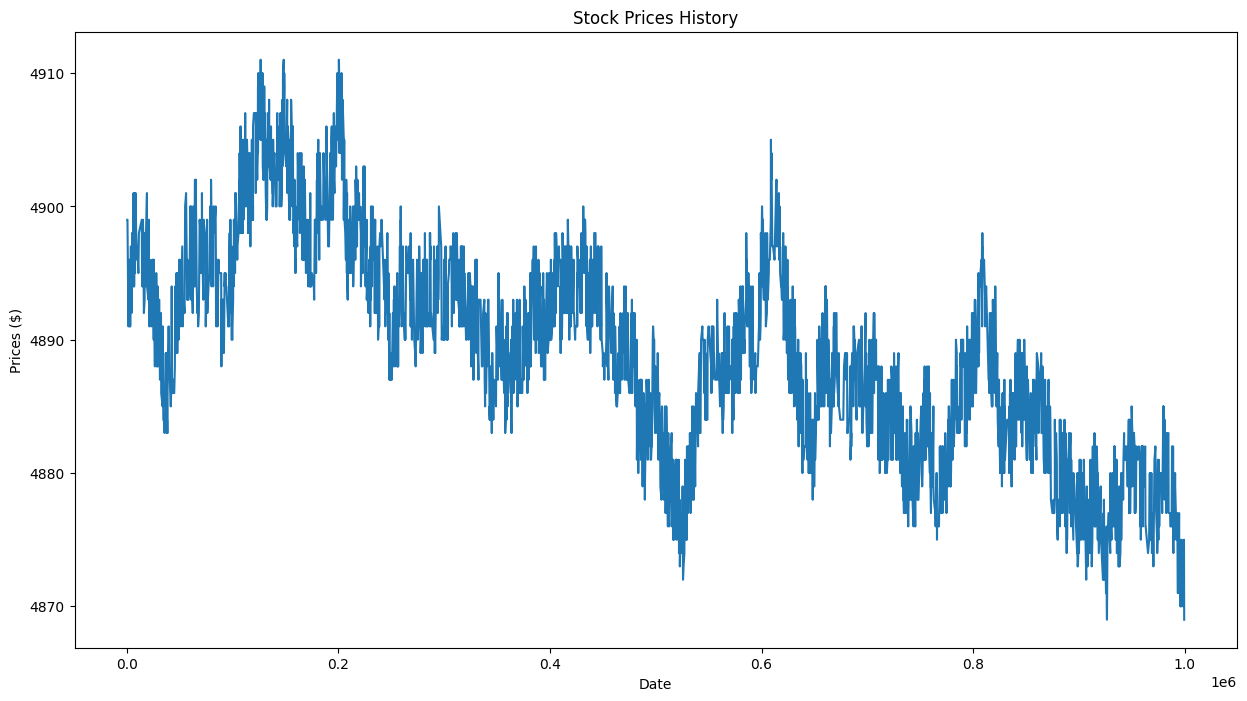

In [17]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
# plt.xlim([0, 999500])
# plt.ylim([9993, 10006])


x = stock_data['timestamp'].tolist()
y = stock_data['price'].tolist()

plt.plot(x,y)
plt.xlabel('Date')
plt.ylabel('Prices ($)')

## Preparation of training set

In [18]:
close_prices = stock_data['price']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Preparation of test Set

In [19]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Setting up LSTM Network Architecture

In [20]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

2023-03-21 21:08:18.577231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
2151/2151 [==============================] - 49s 21ms/step - loss: 0.0081
Epoch 2/3
 960/2151 [============>.................] - ETA: 26s - loss: 0.0069

## Model Evaluation

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

## Visualising the Predicted Price 

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()